In [1]:
!pip3 install tensorflow-estimator==2.6.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.9/462.9 kB 6.4 MB/s eta 0:00:00


In [2]:
import tensorflow as tf
import tensorflow_hub as hub

import matplotlib.pyplot as plt
import tempfile
from six.moves.urllib.request import urlopen
from six import BytesIO

import numpy as np
from PIL import Image, ImageColor, ImageDraw, ImageFont, ImageOps

import time

In [3]:
def display_image(image):
  fig = plt.figure(figsize=(20, 15))
  plt.grid(False)
  plt.imshow(image)

In [4]:
def download_and_resize_image(url, new_width=256, new_height=256, display=False):
    _, filename = tempfile.mkstemp(suffix=".jpg")
    response = urlopen(url)
    image_data = response.read()
    image_data = BytesIO(image_data)  # 이미지 읽기
    pil_image = Image.open(image_data)
    pil_image_rgb = pil_image.convert("RGB")  # RBG로 변환
    pil_image_rgb.save(filename, format="JPEG", quality=90)  # 이미지 저장
    print("Image downloaded to %s." % filename)
    if display:
        display_image(pil_image)
    return filename

In [5]:
def draw_bounding_box_on_image(image, ymin, xmin, ymax, xmax, color, font, thickness=4, display_str_list=()):
    draw = ImageDraw.Draw(image)
    im_width, im_height = image.size
    (left, right, top, bottom) = (xmin * im_width, xmax * im_width, ymin * im_height, ymax * im_height)

    # BBox 테두리 그리기
    draw.line(
        [(left, top), (left, bottom), (right, bottom), (right, top), (left, top)],
        width=thickness,
        fill=color,
    )

    display_str_heights = [font.getbbox(ds)[3] - font.getbbox(ds)[1] for ds in display_str_list]  # getsize() → getbbox()
    total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

    if top > total_display_str_height:
        text_bottom = top
    else:
        text_bottom = top + total_display_str_height

    for display_str in display_str_list[::-1]:
        bbox = font.getbbox(display_str)  # getsize() 대신 getbbox() 사용
        text_width = bbox[2] - bbox[0]
        text_height = bbox[3] - bbox[1]
        margin = np.ceil(0.05 * text_height)

        draw.rectangle(
            [(left, text_bottom - text_height - 2 * margin), (left + text_width, text_bottom)],
            fill=color,
        )
        draw.text((left + margin, text_bottom - text_height - margin), display_str, fill="black", font=font)
        text_bottom -= text_height - 2 * margin

In [6]:
def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1):
    colors = list(ImageColor.colormap.values())

    try:
        font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf", 25)
    except IOError:
        print("Font not found, using default font.")
        font = ImageFont.load_default()

    # BBox 그리기 적용
    for i in range(min(boxes.shape[0], max_boxes)):
        if scores[i] >= min_score:
            ymin, xmin, ymax, xmax = tuple(boxes[i])  # 박스 좌표값
            display_str = "{}: {}%".format(class_names[i].decode("ascii"), int(100 * scores[i]))
            color = colors[hash(class_names[i]) % len(colors)]
            image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
            draw_bounding_box_on_image(image_pil, ymin, xmin, ymax, xmax, color, font, display_str_list=[display_str])
            np.copyto(image, np.array(image_pil))
    return image

Image downloaded to /tmp/tmpg_vooaoh.jpg.


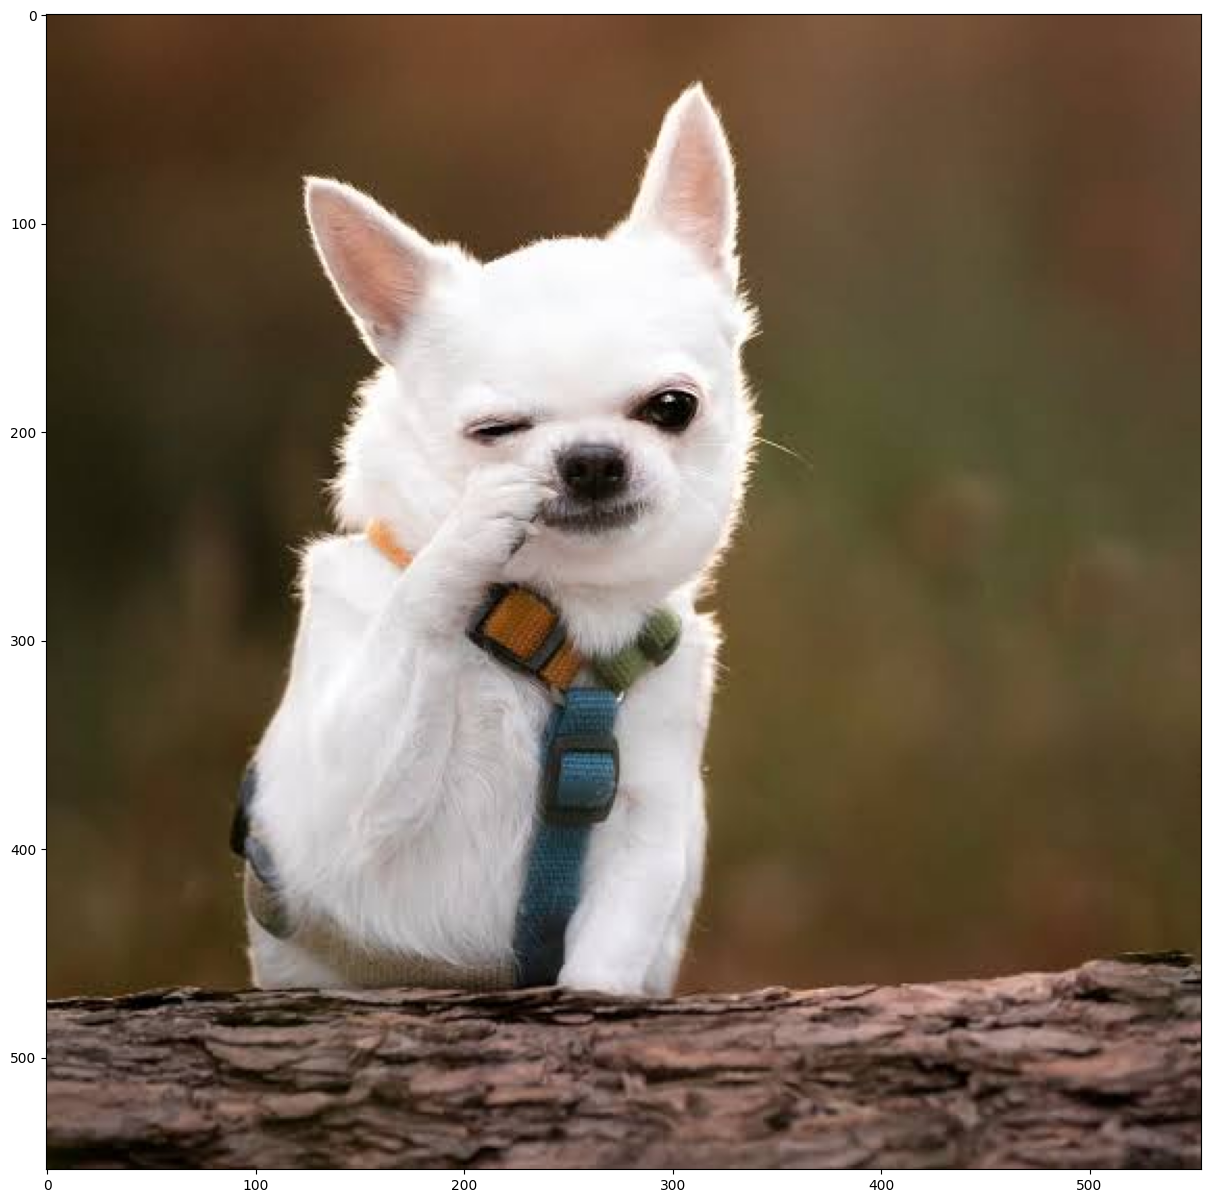

In [7]:
# 새로운 이미지 로드
image_url = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSFUAfyVe3Easiycyh3isP9wDQTYuSmGPsPQvLIJdEYvQ_DsFq5Ez2Nh_QjiS3oZ3B8ZPfK9cZQyIStmQMV1lDPLw"
downloaded_image_path = download_and_resize_image(image_url, 1280, 856, True)

# Faster RCNN (기존 모델)
module_handle_faster_rcnn = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"
detector_faster_rcnn = hub.load(module_handle_faster_rcnn).signatures["default"]

# MobileNetV2 기반 객체 탐지 모델 (새로운 모델)
module_handle_mobilenet = "https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1"
detector_mobilenet = hub.load(module_handle_mobilenet).signatures["default"]


In [8]:
def load_img(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  return img


def run_detector(detector, path):
  img = load_img(path)
  converted_img = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]

  # 소요시간 측정
  start_time = time.time()
  result = detector(converted_img)
  end_time = time.time()

  result = {key: value.numpy() for key, value in result.items()}

  # 이미지 추론 개수와 추론 시간 출력
  print("Found %d objects." % len(result["detection_scores"]))
  print("Inference time: ", end_time - start_time)

  # 이미지 내 박스로 entity, scores를 추가하여 출력
  image_with_boxes = draw_boxes(
      img.numpy(), result["detection_boxes"], result["detection_class_entities"], result["detection_scores"]
  )

  display_image(image_with_boxes)

Faster RCNN 실행 결과
Found 100 objects.
Inference time:  51.12462496757507
MobileNetV2 실행 결과
Found 100 objects.
Inference time:  10.237112283706665
결과 비교
1번째 모델인 Inception ResNet을 사용한 Faster RCNN은 정확도가 높지만 속도가 느렸습니다.
2번째 모델인 MobileNetV2 SSD는 속도가 빠르지만 일부 객체 인식이 정확하지 않을 수 있습니다.


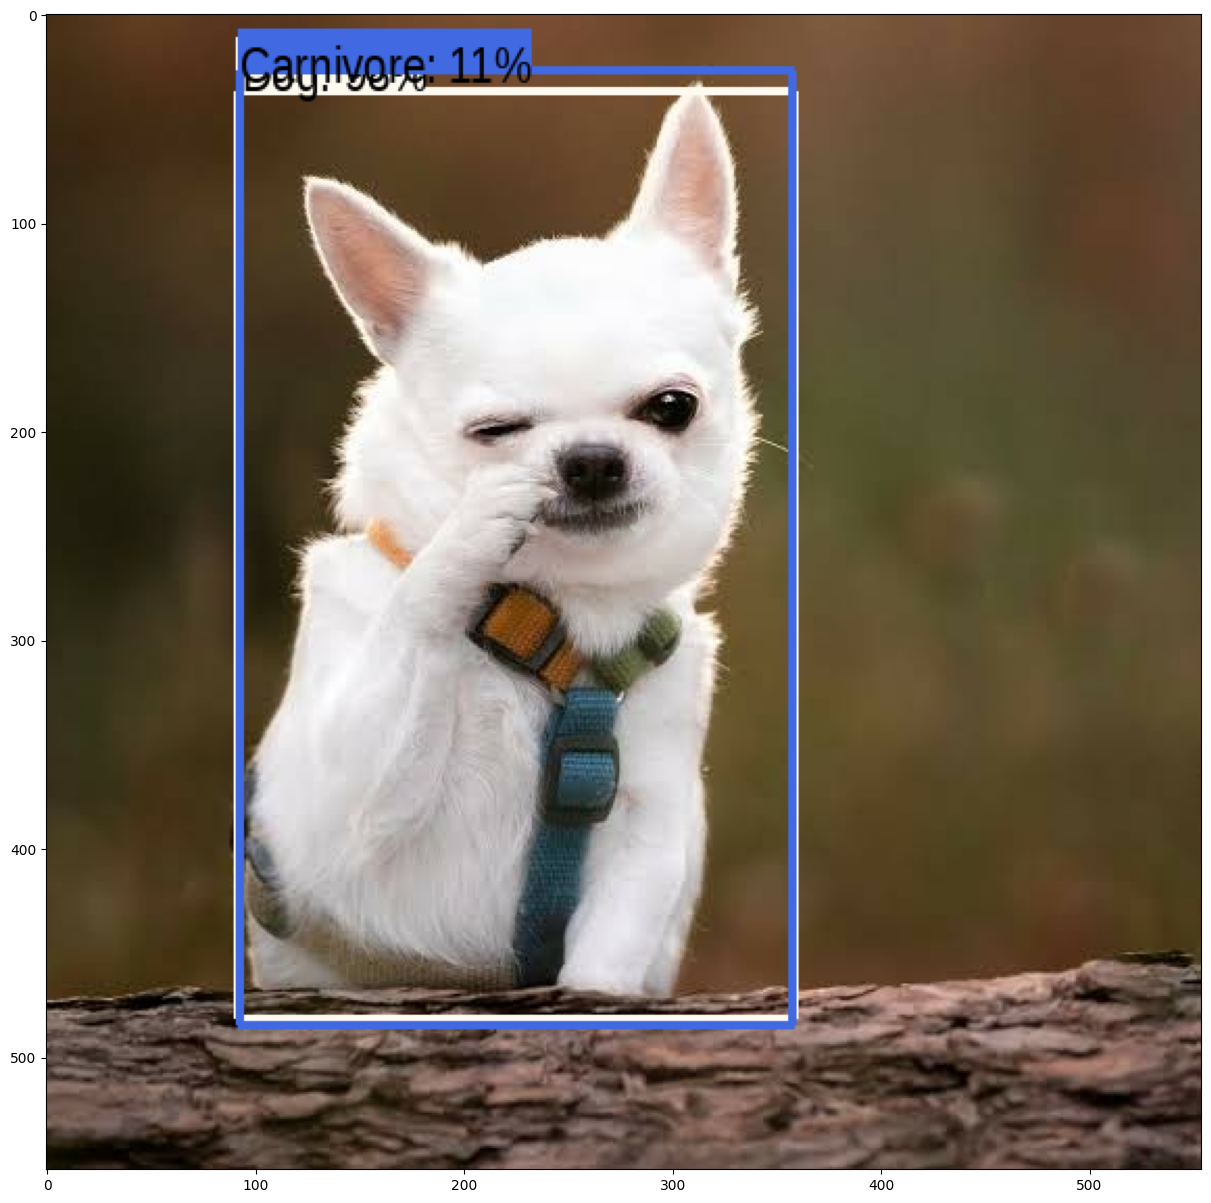

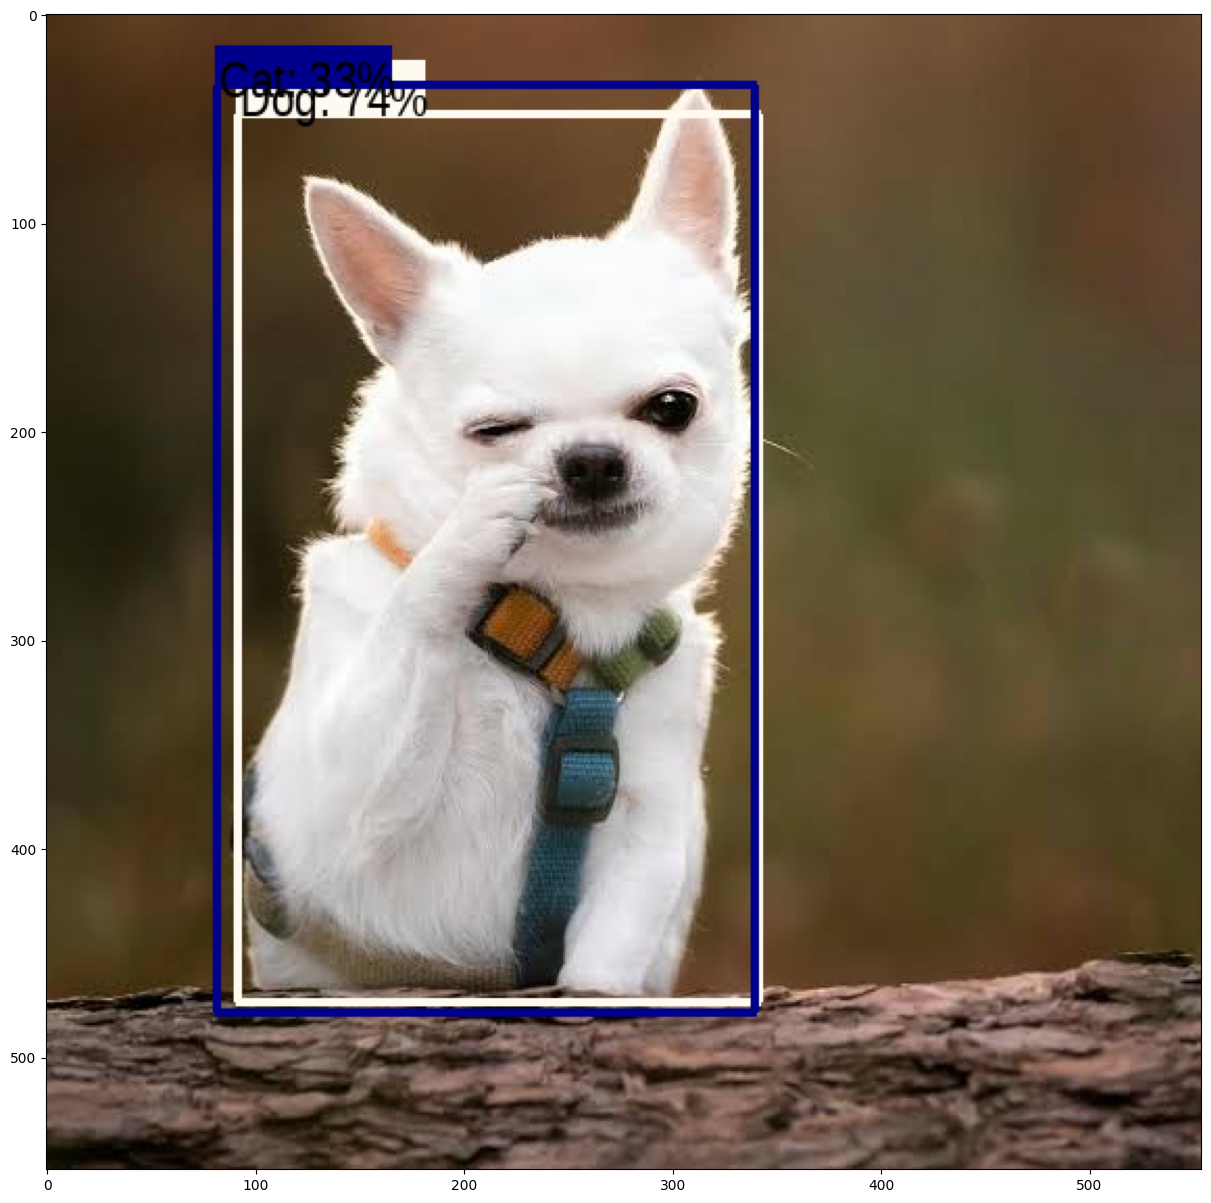

In [9]:

# Faster RCNN 실행
print("Faster RCNN 실행 결과")
run_detector(detector_faster_rcnn, downloaded_image_path)

# MobileNetV2 실행
print("MobileNetV2 실행 결과")
run_detector(detector_mobilenet, downloaded_image_path)

# 결과 비교
print("결과 비교")
print("1번째 모델인 Inception ResNet을 사용한 Faster RCNN은 정확도가 높지만 속도가 느렸습니다.")
print("2번째 모델인 MobileNetV2 SSD는 속도가 빠르지만 일부 객체 인식이 정확하지 않을 수 있습니다.")
